# Домашнее задание HW02



## 1. Загрузка данных и первичный осмотр


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Настройка для отображения графиков
plt.style.use('default')
%matplotlib inline


In [2]:
# Загрузка датасета
df = pd.read_csv('../../S02-hw-dataset.csv')
print(f"Размер датасета: {df.shape}")
print("\nПервые строки датасета:")
df.head(10)


Размер датасета: (41, 5)

Первые строки датасета:


,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296
5,6,120.0,FR,-1,785
6,7,46.0,RU,0,0
7,8,28.0,CN,2,456
8,9,39.0,US,4,980
9,10,24.0,RU,7,511


In [3]:
# Информация о столбцах и типах данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [4]:
# Базовые описательные статистики
df.describe()


,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


## 2. Пропуски, дубликаты и базовый контроль качества


In [5]:
# Доля пропусков в каждом столбце
missing_percent = df.isna().mean() * 100
print("Доля пропусков по столбцам (%):")
print(missing_percent)
print(f"\nВсего пропусков: {df.isna().sum().sum()}")


Доля пропусков по столбцам (%):
user_id      0.000000
age          4.878049
country      0.000000
purchases    0.000000
revenue      0.000000
dtype: float64

Всего пропусков: 2


In [6]:
# Проверка полностью дублирующих строк
duplicated_rows = df[df.duplicated(keep=False)]
print(f"Количество полностью дублирующих строк: {df.duplicated().sum()}")
if len(duplicated_rows) > 0:
    print("\nДублирующие строки:")
    print(duplicated_rows)


Количество полностью дублирующих строк: 1

Дублирующие строки:
    user_id   age country  purchases  revenue
9        10  24.0      RU          7      511
40       10  24.0      RU          7      511


In [7]:
# Проверка подозрительных значений: отрицательные purchases
negative_purchases = df[df['purchases'] < 0]
print("Строки с отрицательным количеством покупок:")
print(negative_purchases)


Строки с отрицательным количеством покупок:
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785


In [8]:
# Проверка подозрительных значений: нереалистичный возраст (> 100 или < 0)
unrealistic_age = df[(df['age'] > 100) | (df['age'] < 0)]
print("Строки с нереалистичным возрастом (<= 0 или > 100):")
print(unrealistic_age)


Строки с нереалистичным возрастом (<= 0 или > 100):
   user_id    age country  purchases  revenue
5        6  120.0      FR         -1      785


In [9]:
# Проверка логических противоречий: нулевой revenue при ненулевых purchases
zero_revenue_with_purchases = df[(df['revenue'] == 0) & (df['purchases'] > 0)]
print("Строки с нулевой выручкой при ненулевых покупках:")
print(zero_revenue_with_purchases)


Строки с нулевой выручкой при ненулевых покупках:
    user_id   age country  purchases  revenue
10       11  24.0      US          4        0


In [10]:
# Проверка: ненулевой revenue при нулевых purchases (может быть возврат или ошибка)
nonzero_revenue_with_zero_purchases = df[(df['revenue'] != 0) & (df['purchases'] == 0)]
print("Строки с ненулевой выручкой при нулевых покупках:")
print(nonzero_revenue_with_zero_purchases)


Строки с ненулевой выручкой при нулевых покупках:
Empty DataFrame
Columns: [user_id, age, country, purchases, revenue]
Index: []


### Выводы по качеству данных

В датасете обнаружены следующие проблемы качества данных:

1. **Пропуски**: В столбце `age` есть пропущенные значения (2 случая - пользователи с ID 5 и 13).

2. **Дубликаты**: Обнаружена одна полностью дублирующая строка (пользователь с ID 10 встречается дважды).

3. **Подозрительные значения**:
   - Отрицательное количество покупок: пользователь с ID 6 имеет `purchases = -1`, что логически невозможно.
   - Нереалистичный возраст: пользователь с ID 6 имеет возраст 120 лет, что маловероятно для реальных данных.
   - Логические противоречия: пользователь с ID 11 имеет нулевую выручку при ненулевых покупках (4 покупки), что может указывать на ошибки в данных или специальные случаи (например, возвраты).

Эти проблемы могут влиять на корректность анализа и требуют дополнительной обработки или исключения проблемных записей при дальнейшей работе.


## 3. Базовый EDA: группировки, агрегаты и частоты


In [11]:
# Частоты по странам
country_counts = df['country'].value_counts()
print("Распределение пользователей по странам:")
print(country_counts)
print(f"\nДоля каждой страны (%):")
print((country_counts / len(df) * 100).round(2))


Распределение пользователей по странам:
country
RU    13
FR    12
US     8
DE     6
CN     2
Name: count, dtype: int64

Доля каждой страны (%):
country
RU    31.71
FR    29.27
US    19.51
DE    14.63
CN     4.88
Name: count, dtype: float64


In [12]:
# Группировка по странам с агрегатами
country_stats = df.groupby('country').agg({
    'purchases': ['mean', 'sum', 'count'],
    'revenue': ['mean', 'sum'],
    'age': 'mean'
}).round(2)
country_stats.columns = ['Средние покупки', 'Всего покупок', 'Количество пользователей', 
                         'Средняя выручка', 'Общая выручка', 'Средний возраст']
print("Статистика по странам:")
country_stats


Статистика по странам:


,Средние покупки,Всего покупок,Количество пользователей,Средняя выручка,Общая выручка,Средний возраст
country,,,,,,
CN,4.50,9,2,1054.00,2108,24.00
DE,6.50,39,6,1445.50,8673,34.60
FR,4.25,51,12,675.92,8111,46.25
RU,4.77,62,13,790.08,10271,30.08
US,4.62,37,8,557.38,4459,36.71


In [13]:
# Создание возрастных групп
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 25, 35, 45, 100], 
                         labels=['18-25', '26-35', '36-45', '46+'],
                         include_lowest=True)

# Статистика по возрастным группам
age_group_stats = df.groupby('age_group').agg({
    'purchases': ['mean', 'count'],
    'revenue': 'mean'
}).round(2)
age_group_stats.columns = ['Средние покупки', 'Количество', 'Средняя выручка']
print("Статистика по возрастным группам:")
age_group_stats


Статистика по возрастным группам:


/var/folders/th/t7bxr_hj7vn3hb2g7vv1r1500000gn/T/ipykernel_3549/3550757469.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_stats = df.groupby('age_group').agg({


,Средние покупки,Количество,Средняя выручка
age_group,,,
18-25,5.17,12,700.67
26-35,4.91,11,946.82
36-45,4.83,6,1106.00
46+,4.33,9,605.78


### Основные наблюдения

1. **Распределение по странам**: Больше всего пользователей из России (RU) - 13 человек (32%), затем идут Франция (FR) - 12 человек (29%), США (US) - 8 человек (20%), Германия (DE) - 6 человек (15%) и Китай (CN) - 2 человека (5%).

2. **Средние значения по странам**: 
   - По средней выручке лидирует Германия (DE) - 1445.50, затем Китай (CN) - 1054.00
   - По среднему количеству покупок лидирует Германия (DE) - 6.50 покупок на пользователя
   - США имеет самую низкую среднюю выручку - 557.38

3. **Возрастные группы**: 
   - Группа 36-45 лет показывает наибольшую среднюю выручку (1106.00)
   - Группа 18-25 лет имеет наибольшее количество пользователей (12 человек)
   - Наблюдается тенденция: средняя выручка выше у пользователей среднего возраста (26-45 лет)

4. **Неожиданные эффекты**: Интересно, что при относительно небольшом количестве пользователей из Германии, они показывают самые высокие средние показатели по выручке и покупкам, что может указывать на более активное поведение этой группы пользователей.


## 4. Визуализация данных в Matplotlib


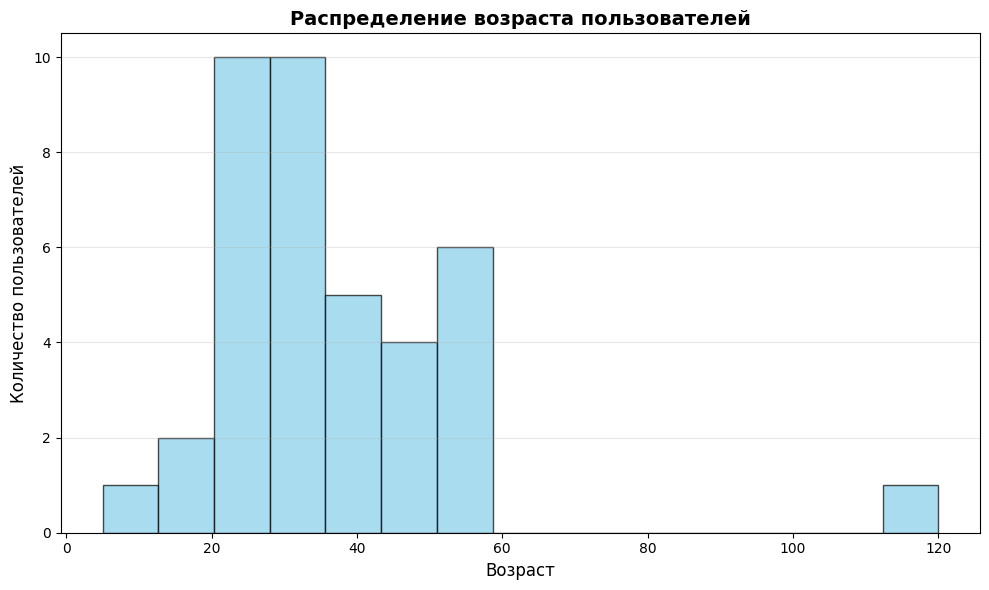

График сохранен в figures/age_histogram.png


In [14]:
# Гистограмма распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(df['age'].dropna(), bins=15, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Возраст', fontsize=12)
plt.ylabel('Количество пользователей', fontsize=12)
plt.title('Распределение возраста пользователей', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/age_histogram.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранен в figures/age_histogram.png")


**Комментарий к гистограмме возраста**: График показывает распределение возраста пользователей. Видно, что большинство пользователей находятся в возрастном диапазоне 20-50 лет, с пиком в районе 25-35 лет. Есть один выброс - пользователь с возрастом 120 лет, который был выявлен ранее как подозрительное значение.


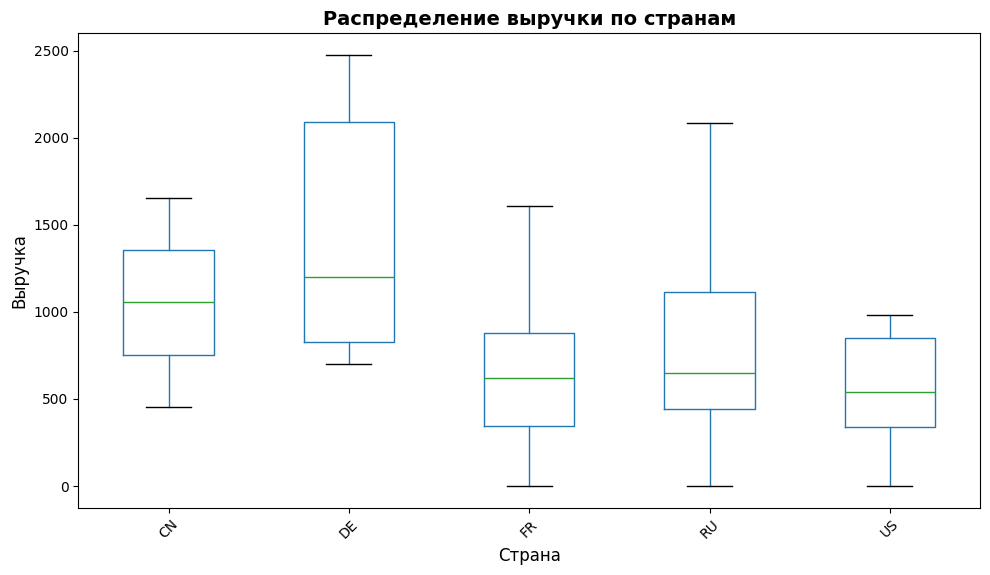

График сохранен в figures/revenue_boxplot_by_country.png


In [15]:
# Боксплот выручки по странам
plt.figure(figsize=(10, 6))
df.boxplot(column='revenue', by='country', ax=plt.gca(), grid=False)
plt.xlabel('Страна', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.title('Распределение выручки по странам', fontsize=14, fontweight='bold')
plt.suptitle('')  # Убираем автоматический заголовок
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/revenue_boxplot_by_country.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранен в figures/revenue_boxplot_by_country.png")


**Комментарий к боксплоту выручки**: Боксплот показывает распределение выручки по странам. Видно, что в Германии (DE) медианная выручка выше, чем в других странах, и разброс значений также больше. Во Франции (FR) и России (RU) распределение более компактное. В США (US) есть несколько выбросов с низкой выручкой. Китай (CN) представлен только двумя точками, поэтому статистика ограничена.


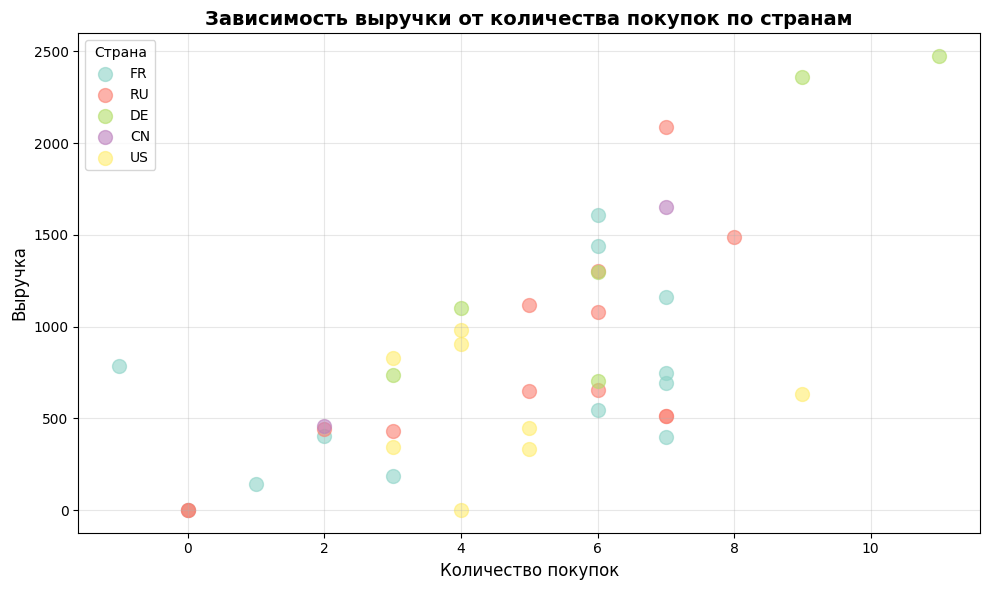

График сохранен в figures/purchases_vs_revenue_scatter.png


In [16]:
# Scatter plot: количество покупок vs выручка с цветом по странам
plt.figure(figsize=(10, 6))
countries = df['country'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(countries)))
color_map = dict(zip(countries, colors))

for country in countries:
    country_data = df[df['country'] == country]
    plt.scatter(country_data['purchases'], country_data['revenue'], 
               label=country, alpha=0.6, s=100, color=color_map[country])

plt.xlabel('Количество покупок', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.title('Зависимость выручки от количества покупок по странам', fontsize=14, fontweight='bold')
plt.legend(title='Страна', loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/purchases_vs_revenue_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("График сохранен в figures/purchases_vs_revenue_scatter.png")


**Комментарий к scatter plot**: Диаграмма рассеяния показывает связь между количеством покупок и выручкой. В целом наблюдается положительная корреляция - чем больше покупок, тем выше выручка. Однако есть несколько интересных наблюдений:
- Некоторые пользователи с большим количеством покупок имеют относительно низкую выручку (возможно, дешевые товары)
- Есть пользователи с нулевой выручкой при ненулевых покупках (выявленные ранее как проблемные данные)
- Пользователи из Германии (DE) в целом показывают более высокую выручку при том же количестве покупок, что может указывать на более дорогие покупки
